# 1-2,图片数据建模流程范例


In [33]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

# 准备数据
- cifar2数据集为cifar10数据集的子集，只包括前两种类别airplane和automobile。
- 训练集有airplane和automobile图片各5000张，测试集有airplane和automobile图片各1000张。
- cifar2任务的目标是训练一个模型来对飞机airplane和机动车automobile两种图片进行分类。







在Pytorch中构建图片数据管道通常有两种方法。

- 第一种是使用 torchvision中的datasets.ImageFolder来读取图片然后用 DataLoader来并行加载。

- 第二种是通过继承 torch.utils.data.Dataset 实现用户自定义读取逻辑然后用 DataLoader来并行加载。
（第二种方法是读取用户自定义数据集的通用方法，既可以读取图片数据集，也可以读取文本数据集。）

本篇我们介绍第一种方法。



In [34]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

In [35]:
# 其中，transforms函数对图像做预处理可以是：归一化(normalize)，尺寸剪裁(resize)，翻转(flip) 等。
transform_train = transforms.Compose([transforms.ToTensor()])
transform_valid = transforms.Compose([transforms.ToTensor()])

In [36]:
ds_train = datasets.ImageFolder("./data/cifar2/train/", \
            transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())
ds_valid = datasets.ImageFolder("./data/cifar2/test/", \
            transform = transform_train,target_transform= lambda t:torch.tensor([t]).float())


In [37]:
print(ds_train.class_to_idx)


{'0_airplane': 0, '1_automobile': 1}


In [38]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=3)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=3)

# https://pytorch.zhangxiann.com/2-tu-pian-chu-li-yu-shu-ju-jia-zai/2.1-dataloader-yu-dataset

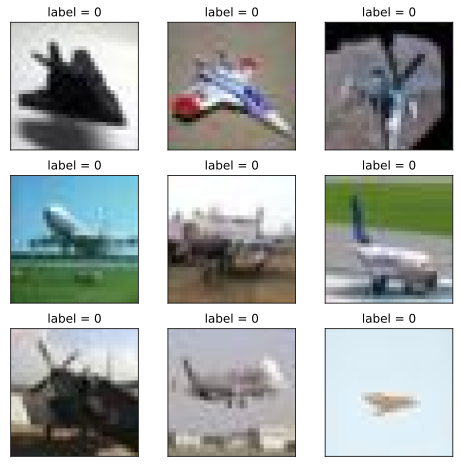

In [39]:

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

In [40]:
# Pytorch的图片默认顺序是 Batch,Channel,Width,Height
# for x in dl_train:
#     print(x.shape) 
#     break

## Define the DL model


使用Pytorch通常有三种方式构建模型：

- 使用nn.Sequential按层顺序构建模型，

- 继承nn.Module基类构建自定义模型，

- 继承nn.Module基类构建模型并辅助应用模型容器(nn.Sequential,nn.ModuleList,nn.ModuleDict)进行封装。

此处选择通过继承nn.Module基类构建自定义模型。

In [41]:
#测试AdaptiveMaxPool2d的效果
pool = nn.AdaptiveMaxPool2d((1,1))
t = torch.randn(10,8,32,32)
pool(t).shape 

# https://blog.csdn.net/u013382233/article/details/85948695

torch.Size([10, 8, 1, 1])

In [42]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size = 3)
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size = 5)
        self.dropout = nn.Dropout2d(p = 0.1)
        self.adaptive_pool = nn.AdaptiveMaxPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64,32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        y = self.sigmoid(x)
        return y
        
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.1, inplace=False)
  (adaptive_pool): AdaptiveMaxPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [43]:
import torchkeras
torchkeras.summary(net,input_shape= (3,32,32))

--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                            [-1, 32, 30, 30]                  896
MaxPool2d-2                         [-1, 32, 15, 15]                    0
Conv2d-3                            [-1, 64, 11, 11]               51,264
MaxPool2d-4                           [-1, 64, 5, 5]                    0
Dropout2d-5                           [-1, 64, 5, 5]                    0
AdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0
Flatten-7                                   [-1, 64]                    0
Linear-8                                    [-1, 32]                2,080
ReLU-9                                      [-1, 32]                    0
Linear-10                                    [-1, 1]                   33
Sigmoid-11                                   [-1, 1]                    0
Net-12                               

'--------------------------------------------------------------------------\nLayer (type)                            Output Shape              Param #\n==========================================================================\nConv2d-1                            [-1, 32, 30, 30]                  896\nMaxPool2d-2                         [-1, 32, 15, 15]                    0\nConv2d-3                            [-1, 64, 11, 11]               51,264\nMaxPool2d-4                           [-1, 64, 5, 5]                    0\nDropout2d-5                           [-1, 64, 5, 5]                    0\nAdaptiveMaxPool2d-6                   [-1, 64, 1, 1]                    0\nFlatten-7                                   [-1, 64]                    0\nLinear-8                                    [-1, 32]                2,080\nReLU-9                                      [-1, 32]                    0\nLinear-10                                    [-1, 1]                   33\nSigmoid-11            

## Train the model
- Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

- 有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

- 此处介绍一种较通用的函数形式训练循环。

In [51]:
import pandas as pd 
from sklearn.metrics import roc_auc_score

model = net
model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)
model.loss_func = torch.nn.BCELoss()
model.metric_func = lambda y_pred,y_true: roc_auc_score(y_true.data.numpy(),y_pred.data.numpy())
model.metric_name = "auc"

In [52]:
def train_step(model,features,labels):
    
    # 训练模式，dropout层发生作用
    model.train()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)

    # 反向传播求梯度
    loss.backward()
    model.optimizer.step()

    return loss.item(),metric.item()

def valid_step(model,features,labels):
    
    # 预测模式，dropout层不发生作用
    model.eval()
    # 关闭梯度计算
    with torch.no_grad():
        predictions = model(features)
        loss = model.loss_func(predictions,labels)
        metric = model.metric_func(predictions,labels)
    
    return loss.item(), metric.item()


# 测试train_step效果
features,labels = next(iter(dl_train))
train_step(model,features,labels)


PicklingError: Can't pickle <function <lambda> at 0x2993b3550>: attribute lookup <lambda> on __main__ failed

In [46]:

# 测试train_step效果
# features,labels = next(iter(dl_train))
# train_step(model,features,labels)

In [47]:
dl_train = DataLoader(ds_train,batch_size = 50,shuffle = True,num_workers=3)
dl_valid = DataLoader(ds_valid,batch_size = 50,shuffle = True,num_workers=3)

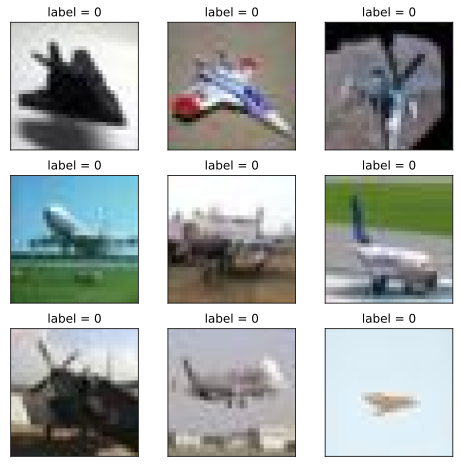

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#查看部分样本
from matplotlib import pyplot as plt 

plt.figure(figsize=(8,8)) 
for i in range(9):
    img,label = ds_train[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()